In [ ]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.inference.iv import BaseDRIVRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [2]:
import pandas as pd
data_url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
college_data = pd.read_csv(data_url)

In [3]:
college_data.columns

Index(['rownames', 'gender', 'ethnicity', 'score', 'fcollege', 'mcollege',
       'home', 'urban', 'unemp', 'wage', 'distance', 'tuition', 'education',
       'income', 'region'],
      dtype='object')

In [4]:
df = college_data.copy()

In [5]:
# 'rownames' 컬럼만 드롭
df = df.drop(columns=["rownames"])

In [6]:
print("샘플 수:", len(df))
df.head()

샘플 수: 4739


,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
0,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
1,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
2,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other


In [7]:
import seaborn as sns

<Axes: xlabel='distance', ylabel='Density'>

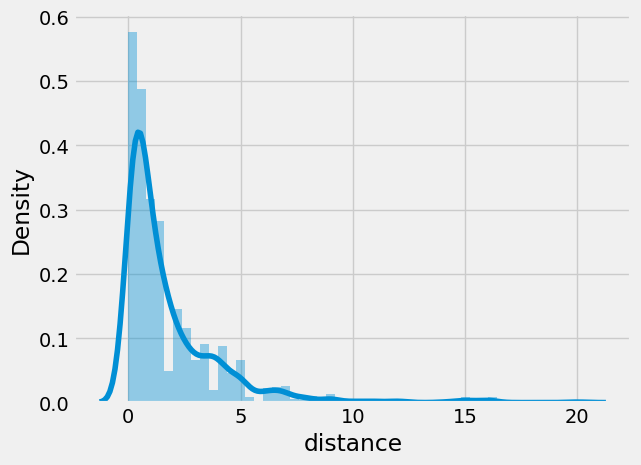

In [8]:
sns.distplot(df["distance"])

<Axes: xlabel='education', ylabel='Density'>

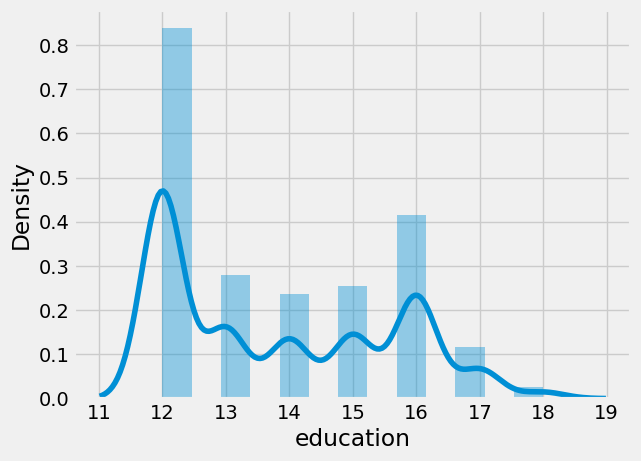

In [9]:
sns.distplot(df["education"])

In [29]:
# 임금이 0 이상인 행만 남기고 로그 임금 변수 생성
df = df[df["wage"] > 0].copy()
df["ln_wage"] = np.log(df["wage"])

## 도구변수(IV)의 조건: Identification Assumptions

도구변수를 활용하기 위해서는 다음 **2가지 조건**을 만족해야 합니다.

1. **Exogeneity & Exclusion Restriction (외생성·배제제약)**  
   - 도구변수(IV)는 **오차항(비관측 요인)**과 상관관계가 없어야 합니다.  
   - 즉, IV가 결과 변수에 직접적인 영향을 미치지 않고, 오직 내생변수를 통해서만 결과에 영향을 주어야 합니다.

2. **Relevance (관련성)**  
   - 도구변수(IV)는 **내생 변수(Endogenous regressor)** 와 유의한 상관관계를 가져야 합니다.  
   - 즉, IV가 내생 변수를 충분히 설명할 수 있어야 합니다.


In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import matplotlib.pyplot as plt

### 1. OLS 내생성 무시한 단순 추정

In [30]:
# 통제변수 정의
controls = "C(gender) + C(ethnicity) + score + C(fcollege) + C(mcollege) + C(home) + C(urban) + unemp + tuition + C(income) + C(region)"

# OLS 추정
ols_formula = f"ln_wage ~ education + {controls}"
ols_res = smf.ols(ols_formula, data=df).fit(cov_type="HC3")
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     102.3
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          1.08e-242
Time:                        03:33:27   Log-Likelihood:                 2907.3
No. Observations:                4739   AIC:                            -5787.
Df Residuals:                    4725   BIC:                            -5696.
Df Model:                          13                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

< OLS 결과 요약 >

- **교육 효과(education):** 계수 -0.0022, p=0.071 → 유의하지 않음  
  → OLS에서는 교육이 임금에 거의 영향을 주지 않는 것으로 보임 (selection bias 가능성).

- **주요 통제변수:**  
  - 서부(region=west), 등록금 높은 주(tuition), 시험점수(score) ↑ → 임금 상승  
  - 저소득 가구(income=low), 비자가(home=no), 비도시(urban=no) → 임금 하락

- **결론:**  
  OLS는 교육 효과를 과소추정하며 인과적 해석이 어려움 → **도구변수(IV) 분석 필요**.

### 2. 도구변수 타당성 확인

In [31]:
# 1단계: education ~ distance + controls
fs_formula = f"education ~ distance + {controls}"
fs_res = smf.ols(fs_formula, data=df).fit(cov_type="HC3")
print(fs_res.summary())

# 1단계에서 distance의 F-stat 확인
fs_f = fs_res.f_test("distance = 0")
print("First-stage F-stat:", float(fs_f.fvalue), "  p-value:", float(fs_f.pvalue))

                            OLS Regression Results                            
Dep. Variable:              education   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     177.7
Date:                Sun, 31 Aug 2025   Prob (F-statistic):               0.00
Time:                        03:35:00   Log-Likelihood:                -8727.3
No. Observations:                4739   AIC:                         1.748e+04
Df Residuals:                    4725   BIC:                         1.757e+04
Df Model:                          13                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

< 도구변수 타당성 (1단계 회귀 결과 요약) >

- **종속변수:** education (교육 연수)  
- **도구변수:** distance (대학까지 거리)

- **distance 계수 = -0.0355, p=0.001**
  - 거리가 멀수록 교육 연수가 감소 (유의미한 음의 관계).  
  - → Relevance 조건 충족.

- **First-stage F-stat = 11.94 (p<0.001)**
  - 기준치(10)를 넘어 **도구변수가 충분히 강함**을 보여줌.  
  - 약도구(weak IV) 우려는 낮음.

- **통제변수 영향**
  - 부모 학력이 높을수록 교육 연수 증가(fcollege, mcollege 유의).  
  - 가구 소득이 낮으면 교육 연수 감소(income=low, 음의 효과).  
  - 시험 점수(score) 높을수록 교육 연수 크게 증가.  

< 결론 >
- `distance`는 교육 연수에 유의하게 작용하며,  
- First-stage F>10로 **도구변수의 Relevance 조건을 충족**.  
- 따라서 IV 추정을 위한 **적절한 도구변수 후보**로 볼 수 있음.

### 3. 도구 변수 분석

In [33]:
# 2SLS (IV) 추정
iv_formula = f"ln_wage ~ 1 + {controls} + [education ~ distance]"
iv_res = IV2SLS.from_formula(iv_formula, data=df).fit(cov_type="robust")
print(iv_res.summary)

# 교육 효과(% 변화 해석)
beta_iv = iv_res.params["education"]
print(f"교육 1년 ↑ → 임금 약 {100*(np.exp(beta_iv)-1):.2f}% 상승")

                          IV-2SLS Estimation Summary                          
Dep. Variable:                ln_wage   R-squared:                     -0.5802
Estimator:                    IV-2SLS   Adj. R-squared:                -0.5846
No. Observations:                4739   F-statistic:                    550.78
Date:                Sun, Aug 31 2025   P-value (F-stat)                0.0000
Time:                        03:38:16   Distribution:                 chi2(13)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                     
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
Intercept                    1.2224     0.3360     3.6383     0.0003      0.5639      1.8

< IV(2SLS) 추정 결과 요약 >

- **종속변수:** ln_wage (임금 로그)
- **내생변수:** education (교육 연수)
- **도구변수:** distance (대학까지 거리)

< 주요 결과 >
- **education 계수 = 0.079 (p=0.024)**
  - 교육 1년 증가 → 임금 약 **8.22% 상승** (통계적으로 유의).
  - OLS에서는 유의하지 않았던 교육 효과가 IV 추정에서는 뚜렷하게 나타남.

- **도구변수(distance)**  
  - education을 설명하는 강한 변수로 작동했으며,  
  - 내생성 문제를 보정한 뒤에도 교육 효과가 긍정적이고 유의하게 추정됨.

- **다른 변수들**  
  - 남성(gender=male): 약 1.7% 더 높은 임금.  
  - Hispanic/Other 인종: 각각 3~7% 더 높은 임금.  
  - 서부(region=west): 약 5.4% 더 높은 임금.  
  - 등록금(tuition) 높을수록 임금 상승 효과 존재.  
  - 시험점수(score): 오히려 음(-)의 계수 (추가 해석 필요).  
  - 부모 학력(fcollege, mcollege)은 음(-)의 효과로 추정됨 (표본 특성일 가능성).  

< 요약 및 결론 >
- **교육은 임금에 실질적이고 유의한 인과적 효과를 미친다.**  
- OLS에서는 교육 효과가 보이지 않았지만, IV 분석으로 **교육 1년 ↑ → 임금 약 8% 상승** 효과가 확인됨.  
- 도구변수 접근법을 통해 selection bias를 교정한 결과, 교육의 가치가 명확히 드러남.

### 4.Durbin–Wu–Hausman (내생성 검정)

In [34]:
# 1단계 잔차 추출
df["vhat"] = fs_res.resid

# education과 vhat을 함께 포함
cf_formula = f"ln_wage ~ education + vhat + {controls}"
cf_res = smf.ols(cf_formula, data=df).fit(cov_type="HC3")
print(cf_res.summary())

print("DWH p-value (vhat):", cf_res.pvalues["vhat"])

                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     96.13
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          2.07e-244
Time:                        03:39:12   Log-Likelihood:                 2912.2
No. Observations:                4739   AIC:                            -5794.
Df Residuals:                    4724   BIC:                            -5697.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

< Durbin–Wu–Hausman (DWH) 내생성 검정 결과 >
- **education 계수 = 0.079 (p=0.003)**
  - 교육 1년 증가 → 임금 약 **7.9% 상승**.
  - 단순 OLS와 달리 교육 효과가 유의하게 양(+)의 방향으로 나타남.

- **vhat 계수 = -0.081 (p=0.002)**
  - 1단계 회귀의 잔차(vhat)가 유의하게 음(-)의 효과를 보임.
  - → 이는 education과 오차항이 상관되어 있다는 신호 → **내생성 존재**.

- **DWH 검정 p-value = 0.0019 (< 0.05)**
  - 귀무가설(H0: education이 외생적임)을 기각.
  - → 교육 변수는 내생적이므로, 단순 OLS 추정치는 편향(bias)됨.
  - → **IV(2SLS) 추정을 사용하는 것이 정당화됨**.

< 해석 >
- OLS로는 교육의 인과 효과를 정확히 추정하기 어려움.  
- DWH 검정이 내생성을 확인했으므로, distance를 도구변수로 한 IV 추정 결과(교육 1년 ↑ → 임금 약 8% 상승)를 신뢰해야 함.

< 교육이 임금에 미치는 인과적 효과 >

- **OLS 추정**에서는 교육과 임금 간 유의한 관계가 나타나지 않았음 → selection bias로 인한 과소추정 가능성.
- **Durbin–Wu–Hausman 검정** 결과, 교육은 내생적 변수임이 확인됨 → OLS 추정치는 편향(bias) 존재.
- **IV(2SLS, 도구변수=distance)** 추정 결과:
  - 교육 1년 증가 → 임금 약 **8% 상승** (p<0.05).
  - 통계적으로 유의하며, 내생성 문제를 보정한 인과적 효과임.

 **결론:** 교육은 임금에 실질적이고 유의한 인과적 상승 효과를 갖는다.  
즉, **교육 연수 1년 증가는 개인의 시간당 임금을 약 8% 높인다**.
